In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp core

# fastai-breadcrumbs.core

> Functions for fastaibreadcrumbs.

In [ ]:
#|hide
from nbdev.showdoc import *

In [ ]:
#|export
import cv2
from fastai.vision.all import *
from fastkaggle import *

## Setting kaggle data on local machine

In [ ]:
#|export
def setup_data(user: str, dataset: str, install=''):
    "Get a path to data for the `user's` `dataset`, downloading it if needed"
    if iskaggle:
        if install:
            os.system(f'pip install -Uqq {install}')
        return Path('../input')/dataset
    else:
        path = Path(dataset)
        from kaggle import api
        if not path.exists():
            api.dataset_download_cli(f'{user}/{dataset}', path=str(path), unzip=True)
        return path

This function is similar to the `setup_comp` function in ["fastkaggle"](https://fastai.github.io/fastkaggle/) which will download the dataset from kaggle and unzip it to your local machine if it's not there already. `setup_data` accepts the user name (which is the userid tagged to that dataset which you want to download) and the dataset name. You may also pass a library name to the `install` argument separated by space. Doing so will install the required libraries on your machine (by default it's blank which means that no library needs to be installed). 

Be sure to have setup a kaggle API for your username and have the kaggle.json downloaded to youtr local machine before using this function.

For example when you do the following-->

```
setup_data('sapal6', 'superresolution')
```

The output would be 

```
Path('superresolution/busystreet')
```

## Crappify your data

Sometimes we need to simulate motion blur. We can do this by using numpy to create a small window of a specific size which can be moved place above an image and then move it around the image and distort the pixels in a particular direction which in effect will simulate a camera shake in a particular direction. At the very basic level this "moving a window around and image and applyiung motion blur" is matrix multiplication for which we can use opencv's [affine transformations](https://docs.opencv.org/3.4/d4/d61/tutorial_warp_affine.html) followed by [getRotationMatrix2D](https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html#gafbbc470ce83812914a70abfb604f4326).

In [ ]:
#|export
def apply_motion_blur(img, sz: int, angle: int):
    """apply motion blur in images at the givn angle and size of blur lines"""
    k = np.zeros((sz, sz), dtype=np.float32)
    k[ (sz-1)// 2 , :] = np.ones(sz, dtype=np.float32)
    k = cv2.warpAffine(k, cv2.getRotationMatrix2D( (sz / 2 -0.5 , sz / 2 -0.5 ) , angle, 1.0), (sz, sz) )  
    k = k * ( 1.0 / np.sum(k) )        
    return cv2.filter2D(img, -1, k)

`apply_motion_blur` is a lower level function which accepts an image (via `img`) and creates blur effect in that image as per the size of the blur (`sz`) which determines the strength of the blur and the `angle` in which the blur is to be applied.

The `crappifier` is the high level function that you would use to simulate motion blur for a single image.

In [ ]:
#|export
@docs
class Crappifier:
    def __init__(self, path_crappy: Path, sz:int=30, angle:int=0):
        self.path_crappy = path_crappy
        self.sz = sz
        self.angle = angle
        
    def __call__(self, f_src: Path):  
        dest = self.path_crappy/f_src.relative_to(f_src.parent)
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = cv2.imread(str(f_src))
        img = apply_motion_blur(img, self.sz, self.angle)
        cv2.imwrite(str(dest), img)
        
    _docs = dict(cls_doc="apply motion blur on images", 
             __call__="call the Crappifier on an image file")

In [ ]:
show_doc(Crappifier.__call__)

---

#### Crappifier.__call__

>      Crappifier.__call__ (f_src:pathlib.Path)

call the Crappifier on an image file

Given a file source (`f_src`) and the destination (`path_crappy`) `crappifier` can create motion blur in the source image as per the size (`sz`) and the `angle` in which the blur needs to be applied.

In [ ]:
hr_path = Path('test/imgs')
crappy_path = Path('test/crappy')
files_hr = get_image_files(hr_path)

In [ ]:
files_hr[0].relative_to(files_hr[0].parent)

Path('test_img.jpg')

In [ ]:
Crappifier(crappy_path)(files_hr[0])

In [ ]:
#|export
def show_plot(fn_first: Path, fn_second: Path, nrow:int, szs: tuple):
    """show two images side by side for given number of rows and figure size"""
    _, axs = plt.subplots(nrow, 2, figsize=szs)
    axs[0].set_title("original")
    axs[1].set_title("crappy")
    axs = axs.flatten()
    img_first = Image.open(fn_first)
    img_second = Image.open(fn_second)
    axs[0].imshow(img_first)
    axs[1].imshow(img_second)

In [ ]:
files_crappy = get_image_files(crappy_path)

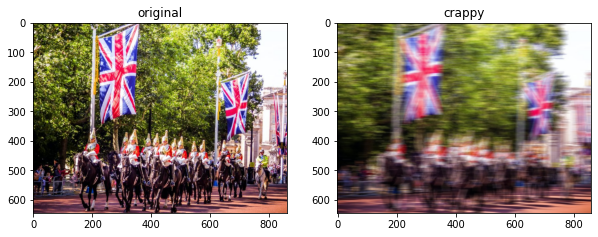

In [ ]:
show_plot(files_hr[0], files_crappy[0], 1, (10, 10))

## Parallely crappify images
When you need to crappify multiple images then save time by parallely crappifying images with `crappify_imgs`.

In [ ]:
#|export
def crappify_imgs(path_hr:Path, path_crappy:Path, sz=30, angle:int=0, n_workers=2):
    'parallely crappify images'
    f = Crappifier(path_crappy, sz=sz, angle=angle)
    imgs_hr = get_image_files(path_hr)
    parallel(f, imgs_hr, n_workers=n_workers)

Provide the `path_hr` for the source image and the `path_crappy` for destination, alongwith the `sz` for the strength of the blur and the angle of the blurs. `n_workers` will determine the number of cpus would be used.

In [ ]:
crappify_imgs(hr_path, crappy_path, n_workers=8)

## Compare three images side by side
When you want to compare three images side by side then use `compare_imgs`. For example, you have a set of original images, crappified images, generated images and you want to compare them side by side.

In [ ]:
#|export
def compare_imgs(origs:L, crappys:L, preds:L, szs: tuple, nrow:int=9, fontsz=100):
    """compare 3 images side by side for given number of rows and figure size"""
    if len(origs) == 1:
        raise Exception("More than one image per source needs to be available.")
    
    if len(origs) == 0:
        raise Exception("No images present in one or more of the sources.")
        
    if len(origs) < nrow:
        nrow=len(origs)
        
    _, axs = plt.subplots(nrow, 3, figsize=szs)
    print(axs)
    axs[0,0].set_title("Original", fontsize=fontsz)
    axs[0,1].set_title("Crappy", fontsize=fontsz)
    axs[0,2].set_title("Generated", fontsize=fontsz)
    [axi.set_axis_off() for axi in axs.ravel()]
    
    for i in range(nrow):
        orig=origs[i]
        crappy=crappys[i]
        pred=preds[i]
        
        orig = Image.open(orig)
        axs[i,0].imshow(orig)
        
        crappy = Image.open(crappy)
        axs[i,1].imshow(crappy)
        
        pred = Image.open(pred)
        axs[i,2].imshow(pred)

Provide the `origs` list for the collection of the original images, `crappys` for the list of crappified images and the `preds` for the list of generated images. The plot sizes can be controlled with the `szs` tuple. The number of plots to be displayed can be controlled via `nrow` and the title size can be controlled by `fontsz`.

In [ ]:
files_gen = get_image_files(Path('test/generated'))
files_gen

(#1) [Path('test/generated/test_img.jpg')]

For example --> 

`compare_imgs(files_hr, files_crappy, files_gen, (64, 64))`

## Quickly create dataloader for Unet

In [ ]:
#|export
def get_unet_dls(bs:int,  source=None,
                  blocks: tuple=(ImageBlock, ImageBlock), dl_type=None, getters=None,
                  n_inp=None, get_items=None, get_y=None, get_x=None, splitter=None,
                  item_tfms=None, batch_tfms=None, **kwargs):
    """function to create the datablock and the dataloader for Unet"""
    dblock = DataBlock(blocks=blocks,
                       dl_type=dl_type,
                       getters=getters,
                       n_inp=n_inp,
                       get_items=None,
                       get_x=get_x,
                       get_y=get_y,
                       splitter=splitter,
                       item_tfms=item_tfms,
                       batch_tfms=batch_tfms)

    dls=dblock.dataloaders(source, bs=bs, **kwargs)
    dls.c=3
    
    return dls

This is a convenience function to setup a datablock and dataloader for a unet when the x and y blocks both are images. All the regular arguments which you pass to a regular fastai dataloader and dataset can be passed here.

In [ ]:
item_tfms=Resize(128, method='squish')
batch_tfms=[*aug_transforms(size=64, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]
dls=get_unet_dls(1, get_image_files('test'), get_y=lambda x: Path('test')/x.relative_to(Path('test')),
                  splitter=RandomSplitter(), item_tfms=item_tfms, batch_tfms=batch_tfms)

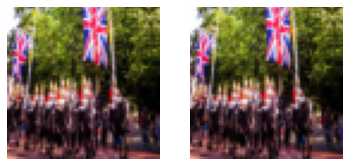

In [ ]:
dls.show_batch()

## Calculate feature loss

In [ ]:
#|export
def gram_matrix(x):
    """function to calculate the gram matrix"""
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [ ]:
#|export
pixel_loss = F.l1_loss

In [ ]:
#|export
class FeatureLoss(Module):
    """Class to calculate feature loss"""
    def __init__(self, m_feat, layer_ids, layer_wgts):
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target, reduction='mean'):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [pixel_loss(input,target,reduction=reduction)]
        self.feat_losses += [pixel_loss(f_in, f_out,reduction=reduction)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [pixel_loss(gram_matrix(f_in), gram_matrix(f_out),reduction=reduction)*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        if reduction=='none': 
            self.feat_losses = [f.mean(dim=[1,2,3]) for f in self.feat_losses[:4]] + [f.mean(dim=[1,2]) for f in self.feat_losses[4:]]
        for n,l in zip(self.metric_names, self.feat_losses): setattr(self, n, l)
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

Feature loss helps the network to compare the pixels of the target and the input image and check if the two images are the same.

We only need to pass the images through the netowrk once. So, we need to turn off the updates to the network weights. `requires_grad_` is like asking the network "do not train".
We need to extract the features from our input image as well as the target image which we can compare later. To extract the features, we will use a simple pre-trained network like "vgg16". 

In [ ]:
def calc_ft_loss(pretrained=True):
    """calculate the feature loss using the given architecture"""
    vgg_m = vgg16_bn(pretrained).features.cuda().eval()
    vgg_m = vgg_m.requires_grad_(False)
    blocks = [i-1 for i,o in enumerate(vgg_m.children()) if isinstance(o,nn.MaxPool2d)]
    return FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

The features are grabbed just before the grid size changes and the maxpooling layer in network is where the grid size change occurs. We iterate over the different layers of the network (children) and then grabbing the layer just before the maxpool layer (i-1) as this is where the grid size changes

## Pushing notebook to kaggle
"fastkaggle" povides a way to push notebooks to kaggle from your local machine but this function deals with notebooks meant for competitions only and as such it takes care of data sources meant for a competition. For ceratin use case we need the ability to attach non-competition data sources to our kaggle notebook.

In [ ]:
#|export
def non_competition_nb_meta(user, id, title, file, dataset=None, private=True, gpu=False, internet=True):
    "Get the `dict` required for a kernel-metadata.json file"
    d = {
      "id": f"{user}/{id}",
      "title": title,
      "code_file": file,
      "language": "python",
      "kernel_type": "notebook",
      "is_private": private,
      "enable_gpu": gpu,
      "enable_internet": internet,
      "keywords": [],
      "dataset_sources": [],
      "kernel_sources": []
    }
    if dataset: d["dataset_sources"] = [f"{user}/{dataset}"]
    return d

In [ ]:
non_competition_nb_meta('sapal6', 'my-notebook', 'My notebook', 'my-notebook.ipynb', dataset='some_data')

{'id': 'sapal6/my-notebook',
 'title': 'My notebook',
 'code_file': 'my-notebook.ipynb',
 'language': 'python',
 'kernel_type': 'notebook',
 'is_private': True,
 'enable_gpu': False,
 'enable_internet': True,
 'keywords': [],
 'dataset_sources': ['sapal6/some_data'],
 'kernel_sources': []}

In [ ]:
import json
from pathlib import Path

In [ ]:
#|export
def push_non_competition_notebook(user, id, title, file, path='.', dataset=None, private=True, gpu=False, internet=True):
    "Push notebook `file` to Kaggle Notebooks"
    meta = non_competition_nb_meta(user, id, title, file=file, dataset=dataset, private=private, gpu=gpu, internet=internet)
    path = Path(path)
    nm = 'kernel-metadata.json'
    path.mkdir(exist_ok=True, parents=True)
    with open(path/nm, 'w') as f: json.dump(meta, f, indent=2)
    from kaggle import api
    api.kernels_push_cli(str(path))

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()